# Análise exploratória de boletins de jurisprudência do TCE-PI

## Introdução
Realiza análise exploratória dos dados extraídos dos boletins de jurisprudência do TCE/PI.

OBS: Foram utilizados boletins de agosto de 2017 a setembro de 2020 (**somente)**.<br>

O dataset utilizado foi gerado a partir do notebook da importação de atos do sistema eTce por meio do script 'importa_processos_etce.py' na pasta 'src\preparation' e contém os seguintes atributos:

|Campo             |Descrição                                                                                           |
|------------------|----------------------------------------------------------------------------------------------------|
|arquivo           |Arquivo de onde foi extraído o dado                                                                 |
|ano_mes           |Ano e mês   obtidos a partir do campo arquivo no formato AAAA-MM                                    |
|sumario           |Sumário do   boletim                                                                                |
|ementa            |Ementa da   decisão proferida                                                                       |
|informacoes       |Informações   do processo                                                                           |
|área_tematica     |Assunto da   decisão (variável alvo)                                                                |
|decisao_tipo      |Tipo da   decisão proferida                                                                         |
|decisao_numero    |Número da   decisão proferida                                                                       |
|decisao_ano       |Ano da   decisão proferida                                                                          |

São executadas as seguintes tarefas:
* Remoção de registros duplicados com base nos campos decisao_numero e decisao_ano;
* Normalização e correção do atributo área_tematica;
* Agrupamento de classes pouco representativas, resultando na criação do atributo assunto_agrupado;
* Armazenamento do dataset resultante em "/data/processed/tcepi_decisoes.csv" para uso nas tarefas de mmodelagem


Fonte: https://www.tce.pi.gov.br/imprensa/publicacoes/boletins-de-jurisprudencia/

Criado po Antonio Filho em 04/10/2020

### Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import altair as alt

import matplotlib.pyplot as plt
from pathlib import Path

import re
import unicodedata

import os
import sys
sys.path.insert(0, os.path.abspath('../../src'))
import nlp_utils

%matplotlib inline

## Carregar os dados

In [2]:
caminho_dados = Path("../../data/raw/")
df = pd.read_csv(caminho_dados/"boletins_jurisprudencia.csv", sep=";")

In [3]:
df.head()

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano
0,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,2017-12,Agente Político. Variação dos subsídios dos ve...,EMENTA. ORÇAMENTO. VARIAÇÃO DOS SUBSÍDIOS DOS ...,(Prestação de Contas. Processo – Relator: Con...,Agente Político,acordao,2400,2017.0
1,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,2017-12,Câmara Municipal. Elevado dispêndio com diárias.,EMENTA. CÂMARA MUNICIPAL. DESPESA. ELEVADO VAL...,(Prestação de Contas. Processo – Relator: Con...,Câmara Municipal,acordao,2348,2017.0
2,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,2017-12,Câmara Municipal. Impossibilidade de realizaçã...,EMENTA. CÂMARA MUNICIPAL. IMPOSSIBILIDADE DA R...,(Consulta. Processo – Relator: Cons. Subst. D...,Câmara Municipal,acordao,2711,2017.0
3,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,2017-12,Contabilidade. Divergência entre o saldo inici...,EMENTA: PRESTAÇÃO DE CONTAS. ENVIO INTEMPESTIV...,(Prestação de Contas. Processo – Relator: Con...,Contabilidade,parecer,267,2017.0
4,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,2017-12,Contabilidade. Divergência entre o valor da am...,EMENTA: PRESTAÇÃO DE CONTAS. FALHAS DE NATUREZ...,(Prestação de Contas. Processo – Relator: Con...,Contabilidade,parecer,249,2017.0


In [4]:
df.shape

(680, 9)

## Análise exploratória

In [5]:
# Verificar se existe registro sem Ementa
df[df.ementa.isna()]

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano


In [6]:
# Qtde. de registros por arquivo importado
print(f'Qtde. de arquivos: {df.arquivo.nunique()}')
df.arquivo.value_counts()

Qtde. de arquivos: 34


Boletim de Jurisprudência TCE-PI - agosto 2020.docx                                       83
Boletim de Jurisprudência TCE-PI - Setembro 2020.docx                                     75
Boletim de Jurisprudência TCE-PI - Agosto-Dezembro - 17 - Consolidação semestral..docx    62
Boletim de Jurisprudência TCE-PI - julho 2020 FINAL.docx                                  58
Boletim de Jurisprudência TCE-PI - Maio - 19.docx                                         36
Boletim de Jurisprudência TCE-PI - Setembro - 18.docx                                     30
Boletim de Jurisprudência TCE-PI - junho - 19.docx                                        24
Boletim de Jurisprudência TCE-PI - junho 2020.docx                                        23
Boletim de Jurisprudência TCE-PI - Dezembro-18 (definitivo).docx                          22
Boletim de Jurisprudência TCE-PI - Novembro - 18.docx                                     20
Boletim de Jurisprudência TCE-PI - Outubro - 18.docx                  

In [7]:
# Quantidade por ano e mês
qtde_por_mes = df.groupby('ano_mes')['arquivo']\
    .count()\
    .reset_index()\
    .rename(columns={'arquivo' : 'quantitativo'})
qtde_por_mes

,ano_mes,quantitativo
0,2017-12,62
1,2018-01,11
2,2018-02,10
3,2018-03,13
4,2018-04,8
5,2018-05,10
6,2018-06,18
7,2018-07,20
8,2018-08,18
9,2018-09,30


In [8]:
alt.Chart(qtde_por_mes).mark_bar(opacity=0.5).encode(
    alt.X("ano_mes"),
    alt.Y("quantitativo", stack=None),
    #alt.Color('legislationType:N', legend=alt.Legend(title="Tipo do Normativo"), scale=alt.Scale(scheme='dark2')),
    tooltip=['ano_mes', 'quantitativo'],
).properties(
    title='Quantitativo de decisões por mês'
).interactive()

alt.Chart(...)

In [9]:
df[df.arquivo == 'Boletim de Jurisprudência TCE-PI - Maio - 19.docx']

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano
312,Boletim de Jurisprudência TCE-PI - Maio - 19.docx,2019-05,Contabilidade. Inconsistência da análise dos b...,PRESTAÇÃO DE CONTAS. GOVERNO. IMPROPRIEDADE VE...,(Prestação de Contas. Processo 6 – Relator Con...,Contabilidade,acordao,241,2019.0
313,Boletim de Jurisprudência TCE-PI - Maio - 19.docx,2019-05,Contabilidade. Precatório do FUNDEF.,DENÚNCIA. SUPOSTAS IRREGULARIDADES NA GESTÃO D...,(Denúncia. Processo 7 – Relator Cons. Joaquim ...,Contabilidade,acordao,241,2019.0
314,Boletim de Jurisprudência TCE-PI - Maio - 19.docx,2019-05,Contabilidade. Créditos suplementares em valor...,CONTAS DE GOVERNO. OCORRÊNCIAS. ABERTURA DE CR...,(Prestação de Contas. Processo – Relatora: Co...,Contabilidade,parecer,41,2019.0
315,Boletim de Jurisprudência TCE-PI - Maio - 19.docx,2019-05,Contabilidade. Desequilíbrio da execução orçam...,CONTAS DO FMAS. EMPENHAMENTO E PAGAMENTO DE DE...,(Prestação de Contas. Processo – Relatora: Co...,Contabilidade,acordao,503,2019.0
316,Boletim de Jurisprudência TCE-PI - Maio - 19.docx,2019-05,Contrato. Sustação do contrato administrativo....,LICITAÇÃO. FALHAS APONTADAS NO CERTAME. SUSTAÇ...,(Inspeção. Processo – Relator: Cons. Subst. J...,Contrato,acordao,720,2019.0
317,Boletim de Jurisprudência TCE-PI - Maio - 19.docx,2019-05,Contrato. Contratação de empresa transporte es...,REPRESENTAÇÃO. IRREGULARIDADES NA ADMINISTRAÇÃ...,(Prestação de Contas. Processo – Relator: Con...,Contrato,acordao,750,2019.0
318,Boletim de Jurisprudência TCE-PI - Maio - 19.docx,2019-05,Convênio. Prestação de contas dos recursos. Ob...,PRESTAÇÃO DE CONTAS. INADIMPLÊNCIA REFERENTE À...,(Representação. Processo 7 – Relator: Cons. Kl...,Convênio,acordao,799,2019.0
319,Boletim de Jurisprudência TCE-PI - Maio - 19.docx,2019-05,Convênio. Comprovação do cumprimento do objeti...,PROCESSUAL. AUSÊNCIA DA PRESTAÇÃO DE CONTAS. \...,(Recurso. Processo 9 – Relator: Cons. Subst. J...,Convênio,acordao,776,2019.0
320,Boletim de Jurisprudência TCE-PI - Maio - 19.docx,2019-05,Despesa. Ilegalidade de atualização dos subsíd...,PRESTAÇÃO DE CONTAS. VARIAÇÃO NO SUBSÍDIO DOS ...,(Prestação de Contas. Processo – Relator: Con...,Despesa,acordao,692,2019.0
321,Boletim de Jurisprudência TCE-PI - Maio - 19.docx,2019-05,Despesa. Variação indevida no subsídio de vere...,PRESTAÇÃO DE CONTAS. CÂMARA MUNICIPAL DE SÃO R...,(Prestação de Contas. Processo – Relatora: Co...,Despesa,acordao,657,2019.0


### Verificação de existência de registros duplicados

In [10]:
qtde_por_decisao = df.groupby(['decisao_numero', 'decisao_ano'])['arquivo']\
    .count()\
    .reset_index()\
    .rename(columns={'arquivo' : 'quantitativo'})
decisoes_duplicadas = qtde_por_decisao[qtde_por_decisao['quantitativo'] > 1]
print('Quantidade de numero e ano de decisão repetidos: ', len(decisoes_duplicadas))
decisoes_duplicadas

Quantidade de numero e ano de decisão repetidos:  52


,decisao_numero,decisao_ano,quantitativo
39,1096,2020.0,3
43,1100,2020.0,2
50,1116,2019.0,2
79,1165,2017.0,2
80,1166,2020.0,2
107,1208,2020.0,2
114,1223,2018.0,2
119,124,2018.0,2
133,1298,2018.0,2
152,1336,2018.0,3


In [11]:
# Fonte: https://thispointer.com/pandas-find-duplicate-rows-in-a-dataframe-based-on-all-or-selected-columns-using-dataframe-duplicated-in-python/
df.duplicated(['decisao_numero', 'decisao_ano'], keep='first')

0      False
1      False
2      False
3      False
4      False
       ...  
675    False
676    False
677    False
678    False
679    False
Length: 680, dtype: bool

In [12]:
df[df.duplicated(['decisao_numero', 'decisao_ano'], keep='first')]

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano
11,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,2017-12,Contrato. Prorrogação. Materiais de consumo. I...,EMENTA. IRREGULARIDADE EM PROCESSOS LICITATÓRI...,(Prestação de Contas. Processo – Relator: Con...,Contrato,acordao,1165,2017.0
40,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,2017-12,Prestação de Contas. Envio tempestivo da maior...,EMENTA: PRESTAÇÃO DE CONTAS. INTEMPESTIVIDADE ...,(Prestação de Contas. Processo – Relator: Con...,Prestação de Contas,acordao,2505,2017.0
53,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,2017-12,Processual. Impossibilidade de análise pelo Tr...,EMENTA: PESSOAL. EXONERAÇÃO DE CONTROLADORA IN...,(Denúncia. Processo – Relator: Cons. Joaquim ...,Processual,acordao,2936,2017.0
105,Boletim de Jurisprudência TCE-PI - Agosto - 18...,2018-08,Despesa. Restos a pagar sem comprovação financ...,CONTAS DO FUNDEB. RESTOS A PAGAR SEM COMPROVAÇ...,(Prestação de Contas. Processo – Relatora: Co...,Despesa,acordao,1223,2018.0
111,Boletim de Jurisprudência TCE-PI - Agosto - 18...,2018-08,Pessoal. Acumulação de cargos. Assessor jurídi...,LICITAÇÃO. CONTRATAÇÃO DE PRESTAÇÃO DE SERVIÇO...,(Denúncia. Processo – Relator: Cons. Joaquim ...,Pessoal,acordao,1298,2018.0
...,...,...,...,...,...,...,...,...,...
620,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,"Despesa. Realização de despesa ilegal, ilegíti...",INADIMPLÊNCIA. ELETROBRÁS.\n1. O pagamento dos...,(Prestação de Contas. Processo – Relator: Con...,Despesa,acordao,672,2020.0
623,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Despesa. Expedição de decretos de emergência p...,CONTAS DE GESTÃO DA PREFEITURA. DESCUMPRIMENTO...,(Prestação de Contas. Processo – Relatora: Co...,Despesa,acordao,1166,2020.0
624,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Despesa. Diferença entre o índice de despesa t...,"DESPESA. Diferença de 0,09% entre o índice da ...",(Prestação de Contas. Processo – Relator: Con...,Despesa,acordao,1583,2020.0
627,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Despesa. Irregularidades em operação de crédit...,SUPOSTAS IRREGULARIDADES EM OPERAÇÃO DE CRÉDIT...,(Embargos. Processo – Relatora: Consª. Lilian...,Despesa,NaN,NaN,NaN


### Remoção dos duplicados
Dada a existência de registros duplicados, optou-se, a principio, por sua remoção, preservando os registros mais recentes.<br>
Fonte: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html

OBS: Como os dados são poucos e há assuntos com pouca representação, decidiu-se por remover duplicatas neste momento.

In [99]:
#df.drop_duplicates(['decisao_numero', 'decisao_ano'], keep='last', inplace=True)

In [13]:
df.shape

(680, 9)

### Análise de áreas temáticas
Como há uma grade variedade de áreas, o que dificulta o trabalho. Vamos agrupar algumas classes.

Essas são as áreas definidas em [RESOLUÇÃO TCE/PI Nº 15, de 14 de agosto de 2017](https://www.tce.pi.gov.br/wp-content/uploads/2017/08/Resolu%C3%A7%C3%A3o-n%C2%BA-15-17-Elabora%C3%A7%C3%A3o-de-ac%C3%B3rd%C3%A3os-e-ementas.pdf)

|                     |  |     |  |   |
|------------------------------------|--------------------|---------------------|---------------------|---|
| Agente Político                    | Assistência Social | Câmara Municipal    | Consórcios Públicos |   |
| Contabilidade                      | Contrato           | Controle Interno    | Controle Social     |   |
| Convênio e Instrumentos Congêneres | Despesa            | Dívida Ativa        | Educação            |   |
| Fundo Especial                     | Licitação          | Orçamento           | Patrimônio          |   |
| Pessoal                            | Planejamento       | Prestação de Contas | Previdência         |   |
| Processual                         | Receita            | Responsabilidade    | Saúde               |   |
| Transparência                      | Tributação         |                     |                     |   |

In [14]:
# Função para normalizar texto, tirando acentuação e colocando em caixa alta
def normalize(text):
    return unicodedata.normalize("NFD", text).encode('ASCII','ignore').decode('ASCII')\
        .strip().upper()

In [15]:
# Qtde. de registros por área temática
print(f'Qtde. de áreas temáticas: {df.area_tematica.unique().size}')
df.area_tematica.value_counts()

Qtde. de áreas temáticas: 29


Licitação                                                     126
Pessoal                                                       122
Despesa                                                        66
Processual                                                     62
Contrato                                                       47
Prestação de Contas                                            46
Previdência                                                    38
Agente Político                                                27
Responsabilidade                                               25
Contabilidade                                                  17
Educação                                                       16
Câmara Municipal                                               15
Transparência                                                  12
Orçamento                                                      10
Saúde                                                           9
Receita   

In [16]:
# Correção de AreaTematica em registro que não foi colocado ponto para separá-la
df.loc[df.area_tematica=='Contabilidade Descumprimento as obrigações constitucionais', 'area_tematica'] = 'Contabilidade'
df.loc[df.area_tematica=='Despesas', 'area_tematica'] = 'Despesa'

In [17]:
# Normalizar áreas
df.area_tematica = df.area_tematica.apply(normalize)

In [18]:
# Qtde. de registros por área temática após correção e normalização
print(f'Qtde. de áreas temáticas após normalização: {df.area_tematica.unique().size}')
pd.DataFrame(df.area_tematica.value_counts())

Qtde. de áreas temáticas após normalização: 25


,area_tematica
LICITACAO,126
PESSOAL,122
DESPESA,67
PROCESSUAL,62
CONTRATO,47
PRESTACAO DE CONTAS,47
PREVIDENCIA,38
AGENTE POLITICO,27
RESPONSABILIDADE,25
CONTABILIDADE,18


In [19]:
qtde_por_area = df.groupby('area_tematica')['arquivo']\
    .count()\
    .reset_index()\
    .rename(columns={'area_tematica': 'assunto', 'arquivo' : 'quantitativo'})
qtde_por_area

,assunto,quantitativo
0,AGENTE POLITICO,27
1,CAMARA MUNICIPAL,15
2,CONTABILIDADE,18
3,CONTRATO,47
4,CONTROLE INTERNO,8
5,CONVENIO,6
6,DESPESA,67
7,EDUCACAO,16
8,FUNDEB,4
9,FUNDEF,4


In [20]:
alt.Chart(qtde_por_area).mark_bar().encode(
    x="quantitativo",
    y=alt.Y("assunto", sort='-x'),
    tooltip=['assunto', 'quantitativo']
)

alt.Chart(...)

### Verificação de distribuição de cauda longa

In [21]:
count_clf_assuntos = pd.DataFrame(df.groupby('area_tematica')['arquivo']\
                              .count()\
                              .sort_values(ascending=False)\
                              .copy())\
                              .rename(columns={'arquivo' : 'quantitativo'})
count_clf_assuntos = count_clf_assuntos.assign(
    soma_acumulada=count_clf_assuntos.quantitativo.cumsum())
count_clf_assuntos = count_clf_assuntos.assign(
    perc_acumulado= 100*count_clf_assuntos.soma_acumulada/count_clf_assuntos.quantitativo.sum(),
    rank=range(1, count_clf_assuntos.shape[0]+1)
)
count_clf_assuntos['rank'] = count_clf_assuntos['rank'].astype('category')
count_clf_assuntos.reset_index(inplace=True)
count_clf_assuntos

,area_tematica,quantitativo,soma_acumulada,perc_acumulado,rank
0,LICITACAO,126,126,18.529412,1
1,PESSOAL,122,248,36.470588,2
2,DESPESA,67,315,46.323529,3
3,PROCESSUAL,62,377,55.441176,4
4,CONTRATO,47,424,62.352941,5
5,PRESTACAO DE CONTAS,47,471,69.264706,6
6,PREVIDENCIA,38,509,74.852941,7
7,AGENTE POLITICO,27,536,78.823529,8
8,RESPONSABILIDADE,25,561,82.500000,9
9,CONTABILIDADE,18,579,85.147059,10


In [22]:
alt.Chart(count_clf_assuntos).mark_area(
    interpolate='step-after',
    line=True
).encode(
    alt.X('rank:O', axis=alt.Axis(values=[5, 10, 15, 20, 30])),
    alt.Y('quantitativo:Q'),
 #   color=alt.value(default_color_1),
).properties(
    width=400,
    height=300,
    title='Distribuição da frequência de ocorrência de assuntos'
).interactive()

alt.Chart(...)

### Agrupamento de dados pouco representativos
Percebe-se que os 10 primeiros assuntos representam 85% do total de ocorrências do dataset. Em função disso, os demais 15% serão agrupado em OUTROS.

Antes, porém, deve-se remover as duplicatas

#### Agrupando os registros

In [23]:
#10 principais assuntos:
count_clf_assuntos[:10]['area_tematica'].to_list()

['LICITACAO',
 'PESSOAL',
 'DESPESA',
 'PROCESSUAL',
 'CONTRATO',
 'PRESTACAO DE CONTAS',
 'PREVIDENCIA',
 'AGENTE POLITICO',
 'RESPONSABILIDADE',
 'CONTABILIDADE']

In [24]:
df['assunto_agrupado'] = df.area_tematica.apply(lambda x: x if x in count_clf_assuntos[:10]['area_tematica'].to_list() else 'OUTROS')
df.loc[:5,['area_tematica', 'assunto_agrupado']]

,area_tematica,assunto_agrupado
0,AGENTE POLITICO,AGENTE POLITICO
1,CAMARA MUNICIPAL,OUTROS
2,CAMARA MUNICIPAL,OUTROS
3,CONTABILIDADE,CONTABILIDADE
4,CONTABILIDADE,CONTABILIDADE
5,CONTABILIDADE,CONTABILIDADE


In [120]:
#pd.DataFrame(pd.DataFrame(Y).groupby('area_tematica')['area_tematica'].count())
#Y = df.area_tematica.apply(lambda x: x if x in count_clf_assuntos[:10]['area_tematica'].to_list() else 'OUTROS')
#pd.DataFrame(zip(Y, df.area_tematica), columns=['y', 'area_tematica']).groupby('y')['area_tematica'].count()

In [25]:
qtde_assuntos_agrupados = df.groupby('assunto_agrupado')['arquivo']\
    .count()\
    .reset_index()\
    .rename(columns={'assunto_agrupado': 'assunto', 'arquivo' : 'quantitativo'})
alt_agrupados = alt.Chart(qtde_assuntos_agrupados).mark_bar().encode(
    alt.X("quantitativo"),
    alt.Y("assunto", sort='-x', title="assunto"),
    tooltip=['assunto', 'quantitativo']
).properties(height=300,
             title='Quantitativo de decisões por assunto agrupado'
)
alt_agrupados

alt.Chart(...)

#### Remover duplicatas
É chegada a hora de resolver o problema das duplicatas, dessa vez, com a utilização de um critério bem mais adequado do que aquele imaginado no momento da detecção do problema: a priorização pela manutenção das 10 principais áreas temáticas, em detrimento daquelas agrupadas na categoria OUTROS

Portanto, Antes de remover, deve-se criar ordenação de acordo com a priorização em que os registros precisam ser mantidos:
1. Estar entre os 10 principais assuntos
2. Entre os 10, ordenar inversamente o ranking, para melhor estratificação das amostras

In [26]:
# Antes de remover, ordenar
#count_clf_assuntos['prioridade'] = count_clf_assuntos['rank'].apply(lambda x: (x-10)*-1 if x <= 10 else x).astype(int)
#count_clf_assuntos.sort_values('prioridade')
df_sd = pd.merge(df, count_clf_assuntos, on='area_tematica')\
    [['arquivo', 'ano_mes', 'sumario', 'ementa', 'informacoes', 'area_tematica', \
     'decisao_tipo', 'decisao_numero', 'decisao_ano', 'assunto_agrupado', 'rank']]

In [27]:
df_sd['prioridade'] = df_sd['rank'].apply(lambda x: (x-10)*-1 if x <= 10 else x).astype(int)
df_sd.sort_values('prioridade', inplace=True)

In [28]:
df_sd

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano,assunto_agrupado,rank,prioridade
44,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,2017-12,Contabilidade. Expressivo montante registrado ...,EMENTA. CONTAS DE GOVERNO. DESCUMPRIMENTO DO L...,(Prestação de Contas. Processo – Relator: Con...,CONTABILIDADE,parecer,271,2017.0,CONTABILIDADE,10,0
43,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,2017-12,Contabilidade. Divergência entre o valor da am...,EMENTA: PRESTAÇÃO DE CONTAS. FALHAS DE NATUREZ...,(Prestação de Contas. Processo – Relator: Con...,CONTABILIDADE,parecer,249,2017.0,CONTABILIDADE,10,0
45,Boletim de Jurisprudência TCE-PI - Janeiro - 1...,2018-01,Contabilidade. Divergência entre informações r...,EMENTA. CONTABILIDADE. DIVERGÊNCIA ENTRE AS RE...,(Prestação de Contas. Processo – Relator: Con...,CONTABILIDADE,acordao,2,2018.0,CONTABILIDADE,10,0
46,Boletim de Jurisprudência TCE-PI - Janeiro - 1...,2018-01,Contabilidade. Restos a pagar sem comprovação ...,EMENTA. PRESTAÇÃO DE CONTAS. FMS 2ª GESTÃO. AU...,(Prestação de Contas. Processo – Relatora: Co...,CONTABILIDADE,acordao,3149,2017.0,CONTABILIDADE,10,0
47,Boletim de Jurisprudência TCE-PI - Julho - 18....,2018-07,Contabilidade. Restos a pagar sem comprovação ...,DESPESA. INSCRIÇÃO DE RESTOS A PAGAR SEM COMP...,(Prestação de Contas. Processo – Relator: Con...,CONTABILIDADE,acordao,1073,2018.0,CONTABILIDADE,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
674,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,FUNDEB. Irregularidade na utilização do precat...,IRREGULARIDADES NA APLICAÇÃO DE PRECATÓRIOS DO...,(Representação. Processo 7 – Relator: Cons. Jo...,FUNDEB,acordao,582,2020.0,OUTROS,21,21
662,Boletim de Jurisprudência TCE-PI - Janeiro - 1...,2018-01,Tributação. Isenções fiscais de ICMS sem a rea...,EMENTA. RENÚNCIA DE RECEITAS. GUERRA FISCAL. F...,(Prestação de Contas. Processo – Relator: Con...,TRIBUTACAO,acordao,3085,2017.0,OUTROS,22,22
663,Boletim de Jurisprudência TCE-PI - Junho - 18....,2018-06,Patrimônio. Inexistência de registros analític...,PRESTAÇÃO DE CONTAS. AUSÊNCIA DE REGISTRO PATR...,(Prestação de Contas. Processo – Relator: Con...,PATRIMONIO,acordao,840,2018.0,OUTROS,23,23
670,Boletim de Jurisprudência TCE-PI - Outubro - 1...,2019-10,Representação. Prestação de contas em atraso c...,REPRESENTAÇÃO. PEDIDO DE BLOQUEIO DE CONTAS. P...,(Prestação de Contas. Processo 9 – Relator: Co...,REPRESENTACAO,acordao,1584,2019.0,OUTROS,24,24


In [29]:
# Remover
df_sd.drop_duplicates(['decisao_numero', 'decisao_ano'], keep='first', inplace=True)

In [30]:
df_sd.shape

(617, 12)

In [31]:
qtde_assuntos_sem_dup = df_sd.groupby('assunto_agrupado')['arquivo']\
    .count()\
    .reset_index()\
    .rename(columns={'assunto_agrupado': 'assunto', 'arquivo' : 'quantitativo'})
alt_sem_dup = alt.Chart(qtde_assuntos_sem_dup).mark_bar().encode(
    alt.X("quantitativo"),
    alt.Y("assunto", sort='-x', title="assunto"),
    tooltip=['assunto', 'quantitativo']
).properties(height=300,
             title='Quantitativo de decisões por assunto sem duplicatas'
)
alt_sem_dup.configure_mark(color='#40A89E')

alt.Chart(...)

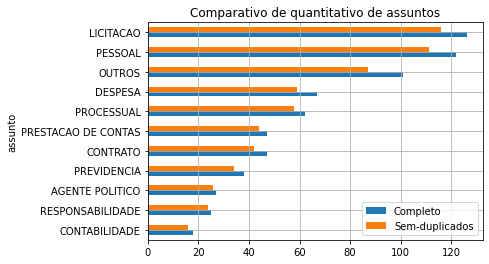

In [32]:
qtde_assuntos_agrupados.merge(qtde_assuntos_sem_dup, on = "assunto").set_index("assunto")\
.rename(columns = {'quantitativo_x': 'Completo', 'quantitativo_y': 'Sem-duplicados'})\
.sort_values('Completo', ascending=True)\
.plot.barh(title='Comparativo de quantitativo de assuntos', grid=True)

In [33]:
df_qtde_compara = pd.concat([qtde_assuntos_agrupados, qtde_assuntos_sem_dup],  ignore_index=True)
df_qtde_compara.loc[:11, 'dataset'] = 'Completo'
df_qtde_compara.loc[11:, 'dataset'] = 'Sem-Duplicados'
df_qtde_compara

,assunto,quantitativo,dataset
0,AGENTE POLITICO,27,Completo
1,CONTABILIDADE,18,Completo
2,CONTRATO,47,Completo
3,DESPESA,67,Completo
4,LICITACAO,126,Completo
5,OUTROS,101,Completo
6,PESSOAL,122,Completo
7,PRESTACAO DE CONTAS,47,Completo
8,PREVIDENCIA,38,Completo
9,PROCESSUAL,62,Completo


In [34]:
qtde_compara = df_qtde_compara.groupby(['assunto', 'dataset'])['quantitativo']\
    .min()\
    .reset_index()\
    .rename(columns={'assunto_agrupado': 'assunto', 'arquivo' : 'quantitativo'})

In [35]:
qtde_compara

,assunto,dataset,quantitativo
0,AGENTE POLITICO,Completo,27
1,AGENTE POLITICO,Sem-Duplicados,26
2,CONTABILIDADE,Completo,18
3,CONTABILIDADE,Sem-Duplicados,16
4,CONTRATO,Completo,47
5,CONTRATO,Sem-Duplicados,42
6,DESPESA,Completo,67
7,DESPESA,Sem-Duplicados,59
8,LICITACAO,Completo,126
9,LICITACAO,Sem-Duplicados,116


In [36]:
qtde_compara = df_qtde_compara.groupby(['assunto', 'dataset'])['quantitativo']\
    .min()\
    .reset_index()\
    .rename(columns={'assunto_agrupado': 'assunto', 'arquivo' : 'quantitativo'})

alt.Chart(qtde_compara).mark_bar().encode(
    x="quantitativo:Q",
    y="dataset:O",
    color='dataset',
    row = 'assunto',
).properties(title='Quantitativo de decisões por assunto sem duplicatas'
).configure_mark(color='#40A89E'
)

alt.Chart(...)

## Salvar dataset para uso na etapa de modelagem

In [37]:
caminho = Path("../../data/processed/tcepi_decisoes.csv")
df_sd.to_csv(caminho, index=False, sep=';')